In [ ]:
import spectral
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
## for 004-specim-fx10.hdr
header_file = r'/media/sasank-v/New Volume/Studies/College/Interships/APPN - ANU/3d_hyperspec_ai/data/csiro_fx10_17_2_wheat/004-specim-fx17.hdr'
img_path = header_file[:-3]+'png'
image = spectral.open_image(header_file)
wavelengths = image.metadata['wavelength']
white_coordinates_path = header_file[:-4] + r"_white_calib.npy"
dark_coordinates_path = header_file[:-4] + r"_dark_calib.npy"

# white_coordinates = np.array([(0, 0), (717, 0), (0, 86), (717, 86)])
# dark_coordinates = np.array([(0, 2022), (717, 2022), (0, 2072), (717, 2072)])
# big_rect = np.array([[[ 153, 43],
#                       [ 870, 43],
#                       [ 153, 2115],
#                       [ 870, 2115]]])


In [3]:
## for 004-specim-fx17.hdr
header_file = r'D:\anu-files\ANU\data\csiro_fx10_17_2_wheat\004-specim-fx17.hdr'
img_path = header_file[:-3]+'png'
image = spectral.open_image(header_file)
wavelengths = image.metadata['wavelength']
white_coordinates_path = header_file[:-4] + r"_white_calib.npy"
dark_coordinates_path = header_file[:-4] + r"_dark_calib.npy"

# white_coordinates = np.array([(0, 0), (447, 0), (0, 21), (447, 21)])
# dark_coordinates = np.array([(0, 2055), (447, 2055), (0, 2082), (447, 2082)])
# big_rect = np.array([[[ 82, 18],
#                       [ 529, 18],
#                       [ 82, 2100],
#                       [ 529, 2100]]])


In [4]:
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

In [5]:
def find_nearest_band(wavelengths, target_wavelength):
    wavelengths_float = np.array([float(w) for w in wavelengths])
    return np.argmin(np.abs(wavelengths_float - target_wavelength))

In [6]:
def get_hyp_rgb(image, wavelengths, save_path):
    
    
    try:
        image = image.load()
    except AttributeError:
        if not isinstance(image, np.ndarray):
            raise ValueError("Input image is neither a recognized format with a load() method nor a numpy array.")
    red_band_index = find_nearest_band(wavelengths, 660)
    green_band_index = find_nearest_band(wavelengths, 550)
    blue_band_index = find_nearest_band(wavelengths, 450)
    # print(wavelengths[:20])   # first 20 wavelength values

    # Extract the RGB bands
    red_band = image[:, :, [red_band_index]]
    green_band = image[:, :, [green_band_index]]
    blue_band = image[:, :, [blue_band_index]]

    # Normalize the bands to the range [0, 1]
    red_normalized = normalize_image(red_band)
    green_normalized = normalize_image(green_band)
    blue_normalized = normalize_image(blue_band)
    
    

    # Stack the normalized bands to create an RGB image
    rgb_image = np.stack((red_normalized, green_normalized, blue_normalized), axis=-1)
    
    # Squeeze any extra dimensions
    rgb_image_squeezed = np.squeeze(rgb_image)
    

    # Convert the RGB image to the range [0, 255] and save it as a PNG file
    rgb_image_uint8 = (rgb_image_squeezed * 255).astype(np.uint8)

    rgb_image_uint8 = cv2.cvtColor(rgb_image_uint8, cv2.COLOR_RGB2BGR)
    try:
        output_path =save_path[:-4]+".png"
        cv2.imwrite(output_path, rgb_image_uint8)
        print(f"Image saved as {output_path}")
    except Exception as e:
        print("Error saving the image:", e)

#     # Display the RGB image
#     import matplotlib.pyplot as plt

    plt.imshow(rgb_image_squeezed)
    plt.show()
    return rgb_image_squeezed

Image saved as D:\anu-files\ANU\data\csiro_fx10_17_2_wheat\004-specim-fx17.png


C:\Users\srira\AppData\Local\Temp\ipykernel_29840\160095164.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized = (image - min_val) / (max_val - min_val)


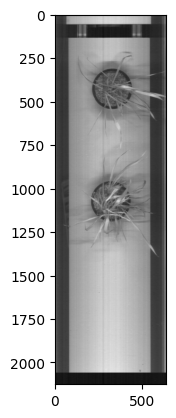

array([[[0.14659686, 0.14659686, 0.14659686],
        [0.13612565, 0.13612565, 0.13612565],
        [0.12565444, 0.12565444, 0.12565444],
        ...,
        [0.16753927, 0.16753927, 0.16753927],
        [0.17801048, 0.17801048, 0.17801048],
        [0.19371727, 0.19371727, 0.19371727]],

       [[0.19895288, 0.19895288, 0.19895288],
        [0.19371727, 0.19371727, 0.19371727],
        [0.18848167, 0.18848167, 0.18848167],
        ...,
        [0.20942408, 0.20942408, 0.20942408],
        [0.20942408, 0.20942408, 0.20942408],
        [0.22513089, 0.22513089, 0.22513089]],

       [[0.21465969, 0.21465969, 0.21465969],
        [0.21465969, 0.21465969, 0.21465969],
        [0.19895288, 0.19895288, 0.19895288],
        ...,
        [0.2460733 , 0.2460733 , 0.2460733 ],
        [0.22513089, 0.22513089, 0.22513089],
        [0.2408377 , 0.2408377 , 0.2408377 ]],

       ...,

       [[0.09947644, 0.09947644, 0.09947644],
        [0.09424084, 0.09424084, 0.09424084],
        [0.09947644, 0

In [7]:

get_hyp_rgb(image, wavelengths, header_file)

In [8]:
def select_coor(img, save_name):
    calib_coor = []
    drawing = False
    start_x, start_y = -1, -1
    img_original = img.copy()

    # Function to display the coordinates and draw rectangles
    def click_event(event, x, y, flags, params):
        nonlocal drawing, start_x, start_y, calib_coor, img, img_original

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            start_x, start_y = x, y

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                img_copy = img.copy()
                cv2.rectangle(img_copy, (start_x, start_y), (x, y), (255, 0, 0), 2)
                cv2.imshow('image', img_copy)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            end_x, end_y = x, y
            cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
            cv2.imshow('image', img)
            print("Start:", start_x, start_y, "End:", end_x, end_y)

            # Store all four coordinates of the selected rectangle
            top_left = (start_x, start_y)
            top_right = (end_x, start_y)
            bottom_left = (start_x, end_y)
            bottom_right = (end_x, end_y)
            calib_coor.append([top_left, top_right, bottom_right, bottom_left])

            # Save the selected rectangle as a separate image without the blue lines
            roi = img_original[start_y:end_y, start_x:end_x]
            cv2.imwrite('./coordinates/' + save_name+'.png', roi)

    # def update_display(*args):
    #     nonlocal img, img_original
    #     x_offset = cv2.getTrackbarPos('Horizontal', 'image')
    #     y_offset = cv2.getTrackbarPos('Vertical', 'image')
    #     img = img_original[y_offset:y_offset + window_height, x_offset:x_offset + window_width]
    #     cv2.imshow('image', img)

    # window_width, window_height = 800, 600
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    # cv2.resizeWindow('image', window_width, window_height)

    # img_height, img_width, _ = img_original.shape
    # cv2.createTrackbar('Horizontal', 'image', 0, img_width - window_width, update_display)
    # cv2.createTrackbar('Vertical', 'image', 0, img_height - window_height, update_display)

    # Displaying the image
    cv2.imshow('image', img)

    # Setting mouse handler for the image and calling the click_event() function
    cv2.setMouseCallback('image', click_event)

    # Wait for a key to be pressed to exit
    cv2.waitKey(0)

    # Close the window
    cv2.destroyAllWindows()

    print(calib_coor)
    # os.makedirs('./data/coordinates_test', exist_ok=True)
    # Derive the save path from the img_path
    save_path = os.path.splitext(img_path)[0]+'_'+save_name + '.npy'
    
    with open(save_path, 'wb') as f:
        np.save(f, calib_coor)

    print(f"Coordinates saved to: {save_path}")


In [9]:
img = cv2.imread(img_path, 1)
select_coor(img, 'white_calib')

Start: 86 18 End: 531 39
[[(86, 18), (531, 18), (531, 39), (86, 39)]]
Coordinates saved to: D:\anu-files\ANU\data\csiro_fx10_17_2_wheat\004-specim-fx17_white_calib.npy


In [10]:
img = cv2.imread(img_path, 1)
select_coor(img, 'dark_calib')

Start: 88 2069 End: 538 2101
[[(88, 2069), (538, 2069), (538, 2101), (88, 2101)]]
Coordinates saved to: D:\anu-files\ANU\data\csiro_fx10_17_2_wheat\004-specim-fx17_dark_calib.npy


In [11]:
def get_rois():
    # Loading the saved dark calibration and white calibration coordinates
    dc = np.load(dark_coordinates_path)
    wc = np.load(white_coordinates_path)
    # Constructing the new, larger rectangle
    big_rect = np.array([[
        [wc[0][0][0], wc[0][0][1]],    # Top-left corner
        [wc[0][1][0], wc[0][1][1]],    # Top-right corner
        [wc[0][3][0], dc[0][3][1]],     # Bottom-left corner
        [wc[0][2][0], dc[0][3][1]]    # Bottom-right corner
    ]])
    

#     # print(big_rect)


#     # Reading the image
#     img_path = r'D:\Projects\AnacondaFiles\APPF_codes\APPF_DATA\hyperspec_calib\003-specim-fx10.png'
#     img = cv2.imread(img_path, 1)

#     # Cropping the image
#     top_left = big_rect[0][0]
#     bottom_right = big_rect[0][3]
#     cropped_img = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]


#     # Deriving the save_path from img_path
#     save_path = img_path.replace(".png", "_crop.png")

#     # Saving the cropped image to the derived save_path
#     cv2.imwrite(save_path, cropped_img)

    return dc, wc, big_rect

[[[ 86  18]
  [531  18]
  [531  39]
  [ 86  39]]]
[[[  88 2069]
  [ 538 2069]
  [ 538 2101]
  [  88 2101]]]
[[[  86   18]
  [ 531   18]
  [  86 2101]
  [ 531 2101]]]
(2083, 445, 224)
Image saved as D:\anu-files\ANU\data\csiro_fx10_17_2_wheat\004-specim-fx17.png


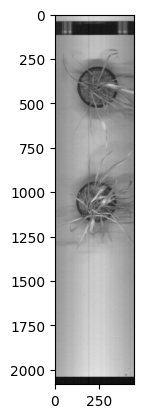

array([[[0.64021164, 0.64021164, 0.64021164],
        [0.64550265, 0.64550265, 0.64550265],
        [0.62962963, 0.62962963, 0.62962963],
        ...,
        [0.65079365, 0.65079365, 0.65079365],
        [0.64550265, 0.64550265, 0.64550265],
        [0.66666667, 0.66666667, 0.66666667]],

       [[0.65608466, 0.65608466, 0.65608466],
        [0.66666667, 0.66666667, 0.66666667],
        [0.65608466, 0.65608466, 0.65608466],
        ...,
        [0.68253968, 0.68253968, 0.68253968],
        [0.67724868, 0.67724868, 0.67724868],
        [0.6984127 , 0.6984127 , 0.6984127 ]],

       [[0.66666667, 0.66666667, 0.66666667],
        [0.68253968, 0.68253968, 0.68253968],
        [0.66137566, 0.66137566, 0.66137566],
        ...,
        [0.69312169, 0.69312169, 0.69312169],
        [0.67724868, 0.67724868, 0.67724868],
        [0.6984127 , 0.6984127 , 0.6984127 ]],

       ...,

       [[0.06349206, 0.06349206, 0.06349206],
        [0.08465608, 0.08465608, 0.08465608],
        [0.07936508, 0

In [12]:
# Open the image
# image = spectral.open_image(header_file)
# wavelengths = image.metadata['wavelength']

# Define the rectangle's coordinates

dc, wc, big_rect = get_rois()
print(wc)
print(dc)
print(big_rect)
# Extract the range for rows and columns
rows_range = (big_rect[0,0,1], big_rect[0,2,1])
cols_range = (big_rect[0,0,0], big_rect[0,1,0])

# Crop the image for all bands
cropped_image = image[rows_range[0]:rows_range[1], cols_range[0]:cols_range[1], :]
print(np.shape(cropped_image))
get_hyp_rgb(cropped_image, wavelengths, header_file)


In [13]:
import numpy as np

def normalize_boxes(wc, dc, big_rect):

    wc = np.array(wc)[0]
    dc = np.array(dc)[0]
    big_rect = np.array(big_rect)[0]

    # Reorder wc and dc to match order (TL, TR, BL, BR)
    reorder_idx = [0, 1, 3, 2]
    wc = wc[reorder_idx]
    dc = dc[reorder_idx]

    # Offset (top-left of big_rect)
    offset = big_rect[0]

    # Relative coordinates
    wc_rel = wc - offset
    dc_rel = dc - offset

    # Force dc to span full width of big_rect
    left_x = 0
    right_x = big_rect[1][0] - big_rect[0][0]

    dc_rel[0][0] = left_x    # TL
    dc_rel[1][0] = right_x   # TR
    dc_rel[2][0] = left_x    # BL
    dc_rel[3][0] = right_x   # BR

    return wc_rel, dc_rel


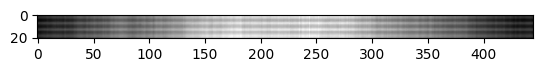

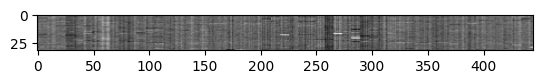

(2083, 445, 224) (2083, 445, 224) (2083, 445, 224)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming cropped_image is already defined and has shape (2076, 676, 224)

# Defining coordinates
white_coordinates, dark_coordinates = normalize_boxes(wc,dc,big_rect)

def extract_and_replicate(image, coordinates, target_shape):
    rows_range = (coordinates[0, 1], coordinates[2, 1])
    cols_range = (coordinates[0, 0], coordinates[1, 0])
    
    # Extracting the region
    region = image[rows_range[0]:rows_range[1], cols_range[0]:cols_range[1], :]
    
    # Displaying extracted region (for one band, e.g., the 50th band)
    plt.imshow(region[:, :, 50], cmap='gray')
    plt.show()
    
    # Replicating the region
    num_repeats = target_shape[0] // (rows_range[1] - rows_range[0])
    replicated = np.concatenate([region] * num_repeats, axis=0)
    
    # If the replicated image is shorter than the target, add additional copies
    if replicated.shape[0] < target_shape[0]:
        additional_repeats = target_shape[0] - replicated.shape[0]
        last_piece = region[:additional_repeats, :, :]
        replicated = np.concatenate([replicated, last_piece], axis=0)
        
    return replicated

# Extracting and replicating
image_shape = np.shape(cropped_image)
replicated_white_image = extract_and_replicate(cropped_image, white_coordinates, image_shape)
replicated_dark_image = extract_and_replicate(cropped_image, dark_coordinates, image_shape)

# Calibrate the image
print(cropped_image.shape, replicated_white_image.shape, replicated_dark_image.shape)


In [15]:
calibrated_image = (cropped_image - replicated_dark_image) / (replicated_white_image - replicated_dark_image)
#  + 1e-10
# Check for any NaN or Inf values in the calibrated image
if np.any(np.isnan(calibrated_image)) or np.any(np.isinf(calibrated_image)):
    print("Warning: The calibrated image contains NaN or Inf values")

In [16]:
def clip_image(image):
    """
    Clips input data to the valid range:
    - [0..1] for floats
    - [0..255] for integers
    """
    if image.dtype.kind == 'f':
        return np.clip(image, 0.0, 1.0)
    elif image.dtype.kind in ('i', 'u'):
        return np.clip(image, 0, 255)
    else:
        raise ValueError("Unsupported data type")

In [17]:
norm_cal_img = clip_image(calibrated_image)

Image saved as D:\anu-files\ANU\data\csiro_fx10_17_2_wheat\004-specim-fx17.png


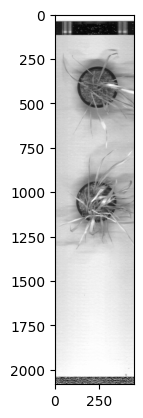

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

In [18]:
get_hyp_rgb(norm_cal_img, wavelengths, header_file)